In [45]:
import requests
url = 'https://apitempo.inmet.gov.br/estacao/2022-01-01/2022-04-25/A201'
resultado = requests.get(url)

In [46]:
import json
dados_org = resultado.json()
dados_str = json.dumps(dados_org)


In [47]:
import pandas as pd
import numpy as np

In [48]:
dados_tabla = pd.read_json(dados_str)
dados_tabla

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,...,VEN_VEL,PTO_MIN,TEM_MAX,TEN_BAT,VEN_RAJ,TEM_CPU,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO
0,BELÉM,1009.0,27.6,-1.411228,1009.0,PA,-0.9,23.6,24.1,-48.439512,...,0.0,23.5,24.3,13.0,2.0,26.0,24.3,96.0,A201,0
1,BELÉM,1009.5,28.0,-1.411228,1009.5,PA,-0.7,23.9,24.3,-48.439512,...,0.0,23.6,24.6,12.9,1.5,26.0,24.5,97.0,A201,100
2,BELÉM,1009.8,27.2,-1.411228,1009.8,PA,0.0,23.6,24.1,-48.439512,...,0.9,23.6,24.6,12.9,4.3,26.0,24.1,97.0,A201,200
3,BELÉM,1009.4,26.3,-1.411228,1009.8,PA,-0.5,23.5,23.9,-48.439512,...,1.6,23.5,24.1,12.9,3.2,25.0,23.9,98.0,A201,300
4,BELÉM,1008.7,27.3,-1.411228,1009.4,PA,-0.4,23.5,23.9,-48.439512,...,0.1,23.5,23.9,12.9,3.2,25.0,23.9,98.0,A201,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,BELÉM,1004.9,31.2,-1.411228,1005.2,PA,1125.2,25.7,28.5,-48.439512,...,1.9,24.4,34.0,13.7,9.7,35.0,28.5,85.0,A201,1900
2756,BELÉM,1005.7,29.6,-1.411228,1006.1,PA,85.1,25.0,25.4,-48.439512,...,0.0,24.5,28.5,13.0,9.7,30.0,25.6,97.0,A201,2000
2757,BELÉM,1005.9,28.7,-1.411228,1006.6,PA,16.5,24.4,24.8,-48.439512,...,0.0,24.1,25.6,13.1,6.4,28.0,25.1,96.0,A201,2100
2758,BELÉM,1006.9,28.8,-1.411228,1007.0,PA,3.0,24.3,24.8,-48.439512,...,0.1,24.0,25.5,13.0,2.9,27.0,25.2,95.0,A201,2200


In [49]:
dados = dados_tabla[['DT_MEDICAO', 'HR_MEDICAO', 'TEM_INS', 'UMD_INS', 'RAD_GLO']]
dados

,DT_MEDICAO,HR_MEDICAO,TEM_INS,UMD_INS,RAD_GLO
0,2022-01-01,0,24.3,96.0,-0.9
1,2022-01-01,100,24.5,97.0,-0.7
2,2022-01-01,200,24.1,97.0,0.0
3,2022-01-01,300,23.9,98.0,-0.5
4,2022-01-01,400,23.9,98.0,-0.4
...,...,...,...,...,...
2755,2022-04-25,1900,28.5,85.0,1125.2
2756,2022-04-25,2000,25.6,97.0,85.1
2757,2022-04-25,2100,25.1,96.0,16.5
2758,2022-04-25,2200,25.2,95.0,3.0


<AxesSubplot:title={'center':'TEM_INS'}, xlabel='HR_MEDICAO'>

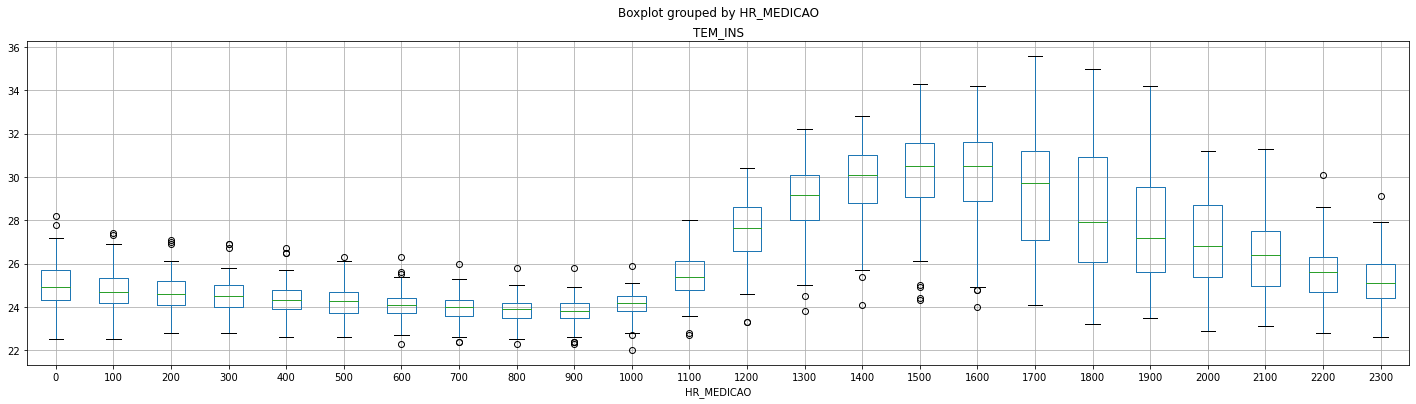

In [50]:
dados.boxplot("TEM_INS", by='HR_MEDICAO', figsize=(24,6))

# Renomia o titulo do nosso dados

In [ ]:
dados.columns = ['DATA','HORARIO', 'TEMPERATURA', 'UNIDADE', 'RADIACAO']

In [ ]:
dados

,DATA,HORARIO,TEMPERATURA,UNIDADE,RADIACAO
0,2022-01-01,0,24.3,96.0,-0.9
1,2022-01-01,100,24.5,97.0,-0.7
2,2022-01-01,200,24.1,97.0,0.0
3,2022-01-01,300,23.9,98.0,-0.5
4,2022-01-01,400,23.9,98.0,-0.4
...,...,...,...,...,...
2755,2022-04-25,1900,28.5,85.0,1125.2
2756,2022-04-25,2000,25.6,97.0,85.1
2757,2022-04-25,2100,25.1,96.0,16.5
2758,2022-04-25,2200,25.2,95.0,3.0


# Verificando a suma de dados null 

In [51]:
dados.apply(pd.isnull).sum()/dados.shape[0]

DT_MEDICAO    0.000000
HR_MEDICAO    0.000000
TEM_INS       0.009058
UMD_INS       0.009058
RAD_GLO       0.009058
dtype: float64

In [44]:
dados[pd.isnull(dados['TEMPERATURA'])]

,DATA,HORARIO,TEMPERATURA,UNIDADE,RADIACAO
323,2022-01-14,1100,NaN,NaN,NaN
479,2022-01-20,2300,NaN,NaN,NaN
480,2022-01-21,0,NaN,NaN,NaN
481,2022-01-21,100,NaN,NaN,NaN
482,2022-01-21,200,NaN,NaN,NaN
483,2022-01-21,300,NaN,NaN,NaN
484,2022-01-21,400,NaN,NaN,NaN
485,2022-01-21,500,NaN,NaN,NaN
486,2022-01-21,600,NaN,NaN,NaN
487,2022-01-21,700,NaN,NaN,NaN
